# Baseline Original Segmentor Analysis

This notebook provides a detailed analysis of each segmentation technique used in the baseline (original) CAPTCHA detection pipeline. The baseline segmentor uses classical computer vision techniques for handling touching and merged characters.

## Segmentation Pipeline Overview

The baseline original segmentor employs the following segmentation strategies:

1. **Connected Components Analysis (CCA)**: Base method for finding character regions
2. **Vertical Projection Splitting**: Uses vertical projection histograms to split touching characters
3. **Uniform Splitting**: Fallback method when projection splitting fails
4. **Line Removal and Cleaning**: Removes noise lines that interfere with segmentation
5. **Merge/Filter Operations**: Handles over-segmentation by merging close boxes
6. **Force Uniform Split**: Last resort for severe under-segmentation cases

Each technique addresses specific challenges in CAPTCHA segmentation, particularly for touching glyphs and merged characters.


In [1]:
# Import required libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from pathlib import Path
from scipy.ndimage import gaussian_filter1d
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")


Libraries imported successfully!


In [2]:
# Load sample CAPTCHA images for analysis
data_dir = Path("../../data/main")
image_files = sorted(list(data_dir.glob("*.png")))[:1000]  # Load up to 1000 samples

sample_images = []
sample_labels = []

for img_path in image_files:
    img = cv2.imread(str(img_path))
    if img is not None:
        sample_images.append(img)
        sample_labels.append(img_path.stem)

print(f"Loaded {len(sample_images)} sample images")
print(f"Sample labels: {sample_labels[:5]}")


Loaded 151 sample images
Sample labels: ['0024miih-0', '002e23-0', '002k-0', '006aguv-0', '00fh-0']


In [3]:
# Import preprocessor for creating binary images
# (Simplified version for demonstration)
from skimage.filters import threshold_sauvola

class SimplePreprocessor:
    """Simplified preprocessor for creating binary images"""
    def _smart_grayscale(self, image):
        b, g, r = cv2.split(image)
        gray_standard = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        stds = [r.std(), g.std(), b.std(), gray_standard.std()]
        best_channel = [r, g, b, gray_standard][np.argmax(stds)]
        multi_channel_max = np.maximum(np.maximum(r, g), b)
        return np.maximum(best_channel, multi_channel_max)
    
    def _enhance_contrast(self, gray):
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        return clahe.apply(gray)
    
    def _adaptive_threshold(self, gray, block_size=15, C=2):
        return cv2.adaptiveThreshold(
            gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY_INV, blockSize=block_size, C=C
        )
    
    def preprocess(self, image):
        gray = self._smart_grayscale(image)
        gray = self._enhance_contrast(gray)
        gray = cv2.equalizeHist(gray)
        _, binary_otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        binary_adaptive = self._adaptive_threshold(gray, block_size=15, C=2)
        thresh_sauvola = threshold_sauvola(gray, window_size=25, k=0.2)
        binary_sauvola = (gray < thresh_sauvola).astype(np.uint8) * 255
        binary = cv2.bitwise_or(binary_otsu, binary_adaptive)
        binary = cv2.bitwise_or(binary, binary_sauvola)
        return binary

preprocessor = SimplePreprocessor()
print("Preprocessor initialized!")


Preprocessor initialized!


In [4]:
# Import the AdvancedCAPTCHASegmenter class from baseline.ipynb
# This segmenter uses vertical projection, uniform splitting, and merge/filter techniques

class AdvancedCAPTCHASegmenter:
    """Advanced segmenter with vertical projection and fallback methods from baseline.ipynb"""
    
    def __init__(self):
        self.failure_modes = {
            'touching_glyphs': 0,
            'over_segmentation': 0,
            'under_segmentation': 0,
            'segmentation_failures': 0,
            'total_processed': 0
        }
    
    def _clean_image(self, binary_image):
        """Remove background lines"""
        h_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1))
        detected_h_lines = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, h_kernel, iterations=1)
        cleaned = cv2.subtract(binary_image, detected_h_lines)
        
        v_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 40))
        detected_v_lines = cv2.morphologyEx(cleaned, cv2.MORPH_OPEN, v_kernel, iterations=1)
        cleaned = cv2.subtract(cleaned, detected_v_lines)
        
        noise_kernel = np.ones((2, 2), np.uint8)
        cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_OPEN, noise_kernel, iterations=1)
        return cleaned
    
    def _find_character_regions(self, binary_image, min_width=3, max_width=None, min_height=5):
        """Find character regions using connected components"""
        contours, _ = cv2.findContours(
            binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
        
        char_boxes = []
        img_height, img_width = binary_image.shape
        
        if max_width is None:
            max_width = img_width // 3
        
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            area = w * h
            
            min_area = max(10, img_height * img_width * 0.0003)
            max_area = img_height * img_width * 0.4
            
            if (w >= min_width and w <= max_width and 
                h >= min_height and h <= img_height * 0.95 and
                area >= min_area and area <= max_area):
                aspect_ratio = w / h if h > 0 else 0
                if 0.08 < aspect_ratio < 3.5:
                    region = binary_image[y:y+h, x:x+w]
                    density = np.sum(region > 0) / area if area > 0 else 0
                    
                    if area < 50:
                        min_density = 0.06
                    elif area < 200:
                        min_density = 0.04
                    else:
                        min_density = 0.03
                    
                    if density >= min_density:
                        char_boxes.append((x, y, x + w, y + h))
        
        return char_boxes
    
    def _vertical_projection_split(self, region, offset_x, offset_y, estimated_chars=2):
        """Split a region using vertical projection"""
        vertical_proj = np.sum(region, axis=0)
        vertical_proj_smooth = gaussian_filter1d(vertical_proj, sigma=1)
        
        if estimated_chars >= 3:
            threshold = np.mean(vertical_proj_smooth) * 0.20
        else:
            threshold = np.mean(vertical_proj_smooth) * 0.25
        
        valleys = []
        for i in range(2, len(vertical_proj_smooth) - 2):
            if (vertical_proj_smooth[i] < threshold and 
                vertical_proj_smooth[i] < vertical_proj_smooth[i-1] and 
                vertical_proj_smooth[i] < vertical_proj_smooth[i+1]):
                valleys.append(i)
        
        if len(valleys) == 0 and estimated_chars >= 2:
            threshold = np.mean(vertical_proj_smooth) * 0.35
            for i in range(2, len(vertical_proj_smooth) - 2):
                if (vertical_proj_smooth[i] < threshold and 
                    vertical_proj_smooth[i] < vertical_proj_smooth[i-1] and 
                    vertical_proj_smooth[i] < vertical_proj_smooth[i+1]):
                    valleys.append(i)
        
        if len(valleys) > 1:
            filtered_valleys = [valleys[0]]
            min_distance = max(3, region.shape[1] // (estimated_chars + 1))
            for valley in valleys[1:]:
                if valley - filtered_valleys[-1] >= min_distance:
                    filtered_valleys.append(valley)
            valleys = filtered_valleys
        
        max_splits = min(estimated_chars - 1, 4)
        if len(valleys) > max_splits:
            valleys = valleys[:max_splits]
        
        if len(valleys) > 0:
            boxes = []
            boundaries = [0] + valleys + [region.shape[1]]
            
            for i in range(len(boundaries) - 1):
                x1_local = boundaries[i]
                x2_local = boundaries[i + 1]
                segment = region[:, x1_local:x2_local]
                y_coords = np.where(np.any(segment > 0, axis=1))[0]
                
                if len(y_coords) > 0:
                    y1_local = y_coords[0]
                    y2_local = y_coords[-1] + 1
                    if x2_local - x1_local >= 2:
                        boxes.append((
                            offset_x + x1_local,
                            offset_y + y1_local,
                            offset_x + x2_local,
                            offset_y + y2_local
                        ))
            
            if len(boxes) > 1:
                return boxes
        
        return [(offset_x, offset_y, offset_x + region.shape[1], offset_y + region.shape[0])]
    
    def _uniform_split_box(self, region, offset_x, offset_y, num_splits):
        """Uniformly split a region"""
        region_width = region.shape[1]
        split_width = region_width / num_splits
        
        boxes = []
        for i in range(num_splits):
            x1_local = int(i * split_width)
            x2_local = int((i + 1) * split_width)
            segment = region[:, x1_local:x2_local]
            y_coords = np.where(np.any(segment > 0, axis=1))[0]
            
            if len(y_coords) > 0:
                y1_local = y_coords[0]
                y2_local = y_coords[-1] + 1
                if x2_local - x1_local >= 2:
                    boxes.append((
                        offset_x + x1_local,
                        offset_y + y1_local,
                        offset_x + x2_local,
                        offset_y + y2_local
                    ))
        
        return boxes if len(boxes) > 1 else [(offset_x, offset_y, offset_x + region.shape[1], offset_y + region.shape[0])]
    
    def _split_touching_characters(self, binary_image, char_boxes, expected_chars):
        """Split wide boxes that likely contain multiple touching characters"""
        new_boxes = []
        img_width = binary_image.shape[1]
        expected_avg_width = img_width / expected_chars if expected_chars > 0 else img_width / 6
        
        if len(char_boxes) > 0:
            widths = [box[2] - box[0] for box in char_boxes]
            actual_avg_width = np.median(widths)
        else:
            actual_avg_width = expected_avg_width
        
        avg_width = min(expected_avg_width, actual_avg_width)
        
        for box in char_boxes:
            x1, y1, x2, y2 = box
            width = x2 - x1
            
            if width > avg_width * 1.2:
                region = binary_image[y1:y2, x1:x2]
                estimated_chars = max(2, int(width / avg_width + 0.3))
                
                split_boxes = self._vertical_projection_split(region, x1, y1, estimated_chars)
                
                if len(split_boxes) > 1:
                    new_boxes.extend(split_boxes)
                else:
                    uniform_boxes = self._uniform_split_box(region, x1, y1, estimated_chars)
                    if len(uniform_boxes) > 1:
                        new_boxes.extend(uniform_boxes)
                    else:
                        new_boxes.append(box)
            else:
                new_boxes.append(box)
        
        return new_boxes
    
    def _merge_or_filter_boxes(self, binary_image, char_boxes, expected_chars):
        """Reduce number of boxes to expected count"""
        if len(char_boxes) <= expected_chars:
            return char_boxes
        
        merged_boxes = []
        sorted_boxes = sorted(char_boxes, key=lambda x: x[0])
        
        i = 0
        while i < len(sorted_boxes):
            current_box = sorted_boxes[i]
            
            if i + 1 < len(sorted_boxes):
                next_box = sorted_boxes[i + 1]
                gap = next_box[0] - current_box[2]
                curr_width = current_box[2] - current_box[0]
                next_width = next_box[2] - next_box[0]
                avg_width = (curr_width + next_width) / 2
                
                if gap < 0 or gap < 5 or gap < avg_width * 0.15:
                    merged_box = (
                        current_box[0],
                        min(current_box[1], next_box[1]),
                        next_box[2],
                        max(current_box[3], next_box[3])
                    )
                    merged_boxes.append(merged_box)
                    i += 2
                    continue
            
            merged_boxes.append(current_box)
            i += 1
        
        if len(merged_boxes) > expected_chars:
            img_height, img_width = binary_image.shape
            box_scores = []
            areas = [(box[2] - box[0]) * (box[3] - box[1]) for box in merged_boxes]
            median_area = np.median(areas)
            
            for box in merged_boxes:
                x1, y1, x2, y2 = box
                w, h = x2 - x1, y2 - y1
                area = w * h
                region = binary_image[y1:y2, x1:x2]
                density = np.sum(region > 127) / area if area > 0 else 0
                
                score = area
                if area < median_area * 0.3:
                    score *= 0.2
                if density < 0.05:
                    score *= 0.3
                aspect = w / h if h > 0 else 0
                if aspect < 0.15 or aspect > 3.0:
                    score *= 0.5
                if h < img_height * 0.15:
                    score *= 0.4
                
                box_scores.append((box, score))
            
            box_scores.sort(key=lambda x: x[1], reverse=True)
            merged_boxes = [box for box, score in box_scores[:expected_chars]]
            merged_boxes = sorted(merged_boxes, key=lambda x: x[0])
        
        return merged_boxes
    
    def _force_uniform_split(self, binary_image, char_boxes, expected_chars):
        """Force split boxes uniformly when other methods fail"""
        if expected_chars is None or expected_chars <= 0 or len(char_boxes) == 0:
            return char_boxes
        
        img_height, img_width = binary_image.shape
        expected_char_width = img_width / expected_chars
        
        new_boxes = []
        
        for box in char_boxes:
            x1, y1, x2, y2 = box
            box_width = x2 - x1
            estimated_chars_in_box = max(1, round(box_width / expected_char_width))
            
            if estimated_chars_in_box > 1:
                split_width = box_width / estimated_chars_in_box
                for j in range(estimated_chars_in_box):
                    split_x1 = int(x1 + j * split_width)
                    split_x2 = int(x1 + (j + 1) * split_width)
                    split_region = binary_image[y1:y2, split_x1:split_x2]
                    y_coords = np.where(np.any(split_region > 0, axis=1))[0]
                    
                    if len(y_coords) > 0:
                        split_y1 = y1 + y_coords[0]
                        split_y2 = y1 + y_coords[-1] + 1
                    else:
                        split_y1, split_y2 = y1, y2
                    
                    new_boxes.append((split_x1, split_y1, split_x2, split_y2))
            else:
                new_boxes.append(box)
        
        if len(new_boxes) < expected_chars:
            uniform_width = img_width / expected_chars
            new_boxes = []
            y_coords_all = np.where(np.any(binary_image > 0, axis=1))[0]
            if len(y_coords_all) > 0:
                y_min = y_coords_all[0]
                y_max = y_coords_all[-1] + 1
            else:
                y_min, y_max = 0, img_height
            
            for i in range(expected_chars):
                x1_uniform = int(i * uniform_width)
                x2_uniform = int((i + 1) * uniform_width)
                region = binary_image[y_min:y_max, x1_uniform:x2_uniform]
                if np.sum(region > 0) > 3:
                    new_boxes.append((x1_uniform, y_min, x2_uniform, y_max))
        
        return new_boxes if len(new_boxes) > 0 else char_boxes
    
    def segment(self, binary_image, expected_chars=None, 
                min_char_width=5, max_char_width=None, min_char_height=10):
        """Main segmentation pipeline"""
        self.failure_modes['total_processed'] += 1
        
        if binary_image.max() <= 1:
            binary_image = (binary_image * 255).astype(np.uint8)
        
        cleaned = self._clean_image(binary_image)
        char_boxes = self._find_character_regions(cleaned, min_char_width, max_char_width, min_char_height)
        
        if len(char_boxes) == 0:
            char_boxes = self._find_character_regions(
                binary_image, max(1, min_char_width - 2), max_char_width, max(1, min_char_height - 3)
            )
            self.failure_modes['segmentation_failures'] += 1
        
        if expected_chars is not None and len(char_boxes) > 0:
            missing_chars = expected_chars - len(char_boxes)
            extra_chars = len(char_boxes) - expected_chars
            
            if missing_chars >= 2 and missing_chars / expected_chars >= 0.35:
                char_boxes = self._split_touching_characters(cleaned, char_boxes, expected_chars)
                self.failure_modes['touching_glyphs'] += 1
                
                if len(char_boxes) < expected_chars - 1:
                    char_boxes = self._force_uniform_split(binary_image, char_boxes, expected_chars)
                    self.failure_modes['under_segmentation'] += 1
            elif extra_chars >= 1:
                char_boxes = self._merge_or_filter_boxes(cleaned, char_boxes, expected_chars)
                self.failure_modes['over_segmentation'] += 1
        
        return sorted(char_boxes, key=lambda x: x[0])

# Initialize segmenter
segmenter = AdvancedCAPTCHASegmenter()
print("Segmenter initialized!")


Segmenter initialized!


## Technique 1: Connected Components Analysis (CCA)

**Problem**: Need to identify individual character regions in a binary image. Simple thresholding alone doesn't separate characters.

**Solution**: Use connected components analysis to find all connected regions:
- Find contours using OpenCV's `findContours`
- Filter regions by size, aspect ratio, and density
- Validate regions to ensure they represent characters
- Extract bounding boxes for each valid component

**Improvement**: Provides the foundation for segmentation by identifying all potential character regions, which can then be refined by other techniques.


TECHNIQUE 1: CONNECTED COMPONENTS ANALYSIS

Example 1: 0024miih-0


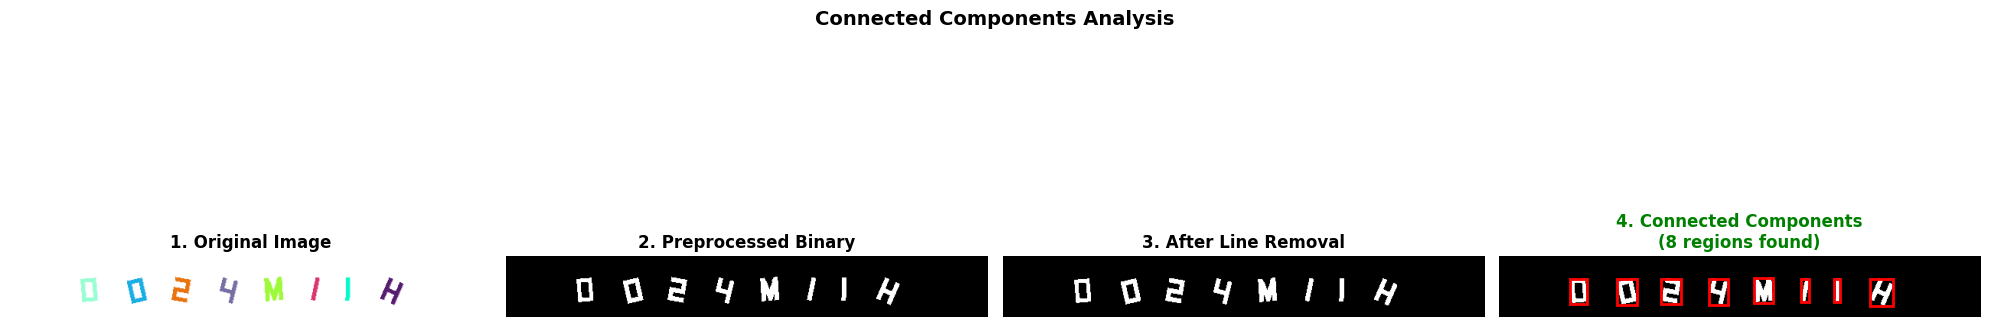

Found 8 character regions

Example 2: 002e23-0


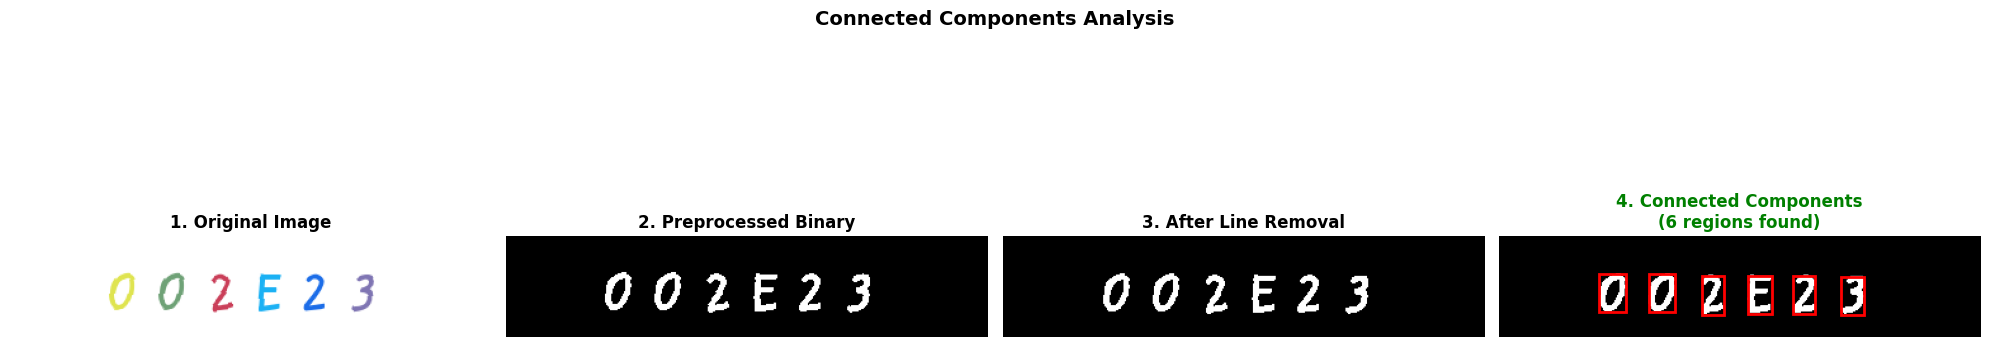

Found 6 character regions

Example 3: 002k-0


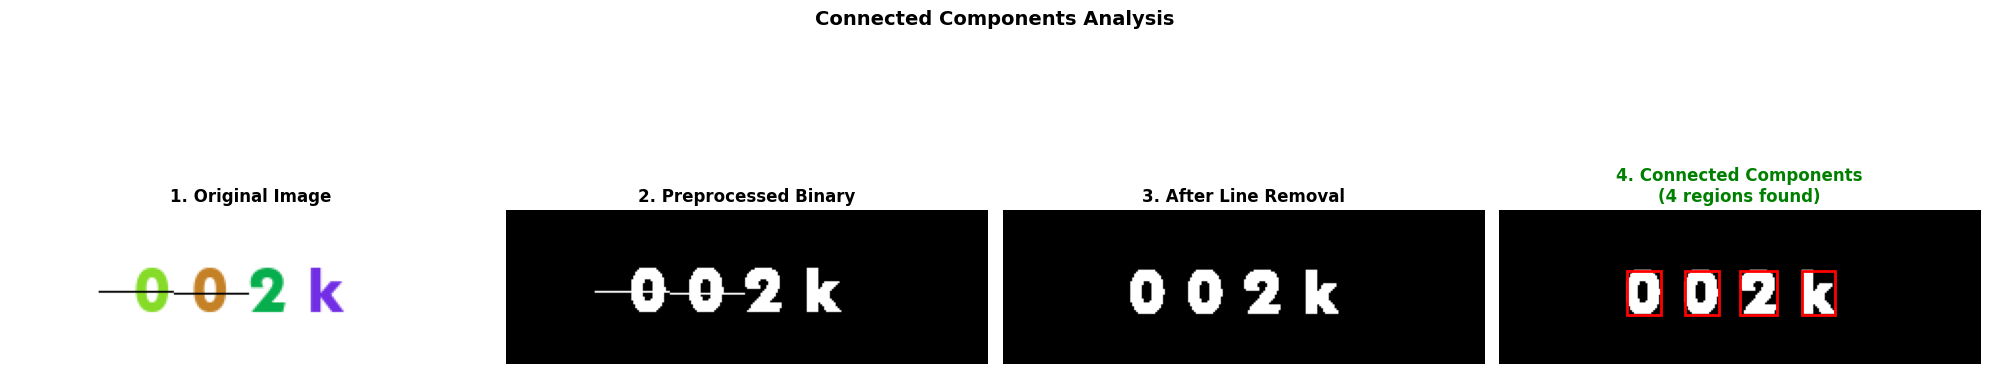

Found 4 character regions



In [5]:
# Visualize Connected Components Analysis
def visualize_cca(image, preprocessor, segmenter):
    """Visualize the connected components analysis process"""
    
    # Preprocess to get binary
    binary = preprocessor.preprocess(image)
    
    # Clean image
    cleaned = segmenter._clean_image(binary)
    
    # Find components
    components = segmenter._find_character_regions(cleaned, min_width=5, min_height=10)
    
    # Create visualization
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    # Original
    axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0].set_title('1. Original Image', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # Binary
    axes[1].imshow(binary, cmap='gray')
    axes[1].set_title('2. Preprocessed Binary', fontsize=12, fontweight='bold')
    axes[1].axis('off')
    
    # Cleaned
    axes[2].imshow(cleaned, cmap='gray')
    axes[2].set_title('3. After Line Removal', fontsize=12, fontweight='bold')
    axes[2].axis('off')
    
    # Components found
    axes[3].imshow(cleaned, cmap='gray')
    axes[3].set_title(f'4. Connected Components\n({len(components)} regions found)', 
                     fontsize=12, fontweight='bold', color='green')
    for x1, y1, x2, y2 in components:
        rect = Rectangle((x1, y1), x2-x1, y2-y1, 
                        linewidth=2, edgecolor='red', facecolor='none')
        axes[3].add_patch(rect)
    axes[3].axis('off')
    
    plt.suptitle('Connected Components Analysis', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    print(f"Found {len(components)} character regions")
    print()
    
    return {'components': len(components)}

# Test on multiple samples
print("="*70)
print("TECHNIQUE 1: CONNECTED COMPONENTS ANALYSIS")
print("="*70)
print()

for i, (img, label) in enumerate(zip(sample_images[:3], sample_labels[:3])):
    print(f"Example {i+1}: {label}")
    visualize_cca(img, preprocessor, segmenter)


## Technique 2: Vertical Projection Splitting

**Problem**: When characters touch or merge, they form a single connected component. Standard CCA cannot separate them, leading to under-segmentation.

**Solution**: Use vertical projection histogram to find split points:
- Calculate vertical projection (sum of pixels in each column)
- Smooth the projection to reduce noise
- Find local minima (valleys) in the projection
- Use valleys as split points between characters
- Adaptive threshold based on estimated number of characters

**Improvement**: Handles touching characters by analyzing pixel distribution patterns, enabling accurate splitting at character boundaries.


TECHNIQUE 2: VERTICAL PROJECTION SPLITTING

Searching for samples with wide components...
Found 3 suitable samples. Showing examples:

Example 1: 00wi5-0 (sample #8)


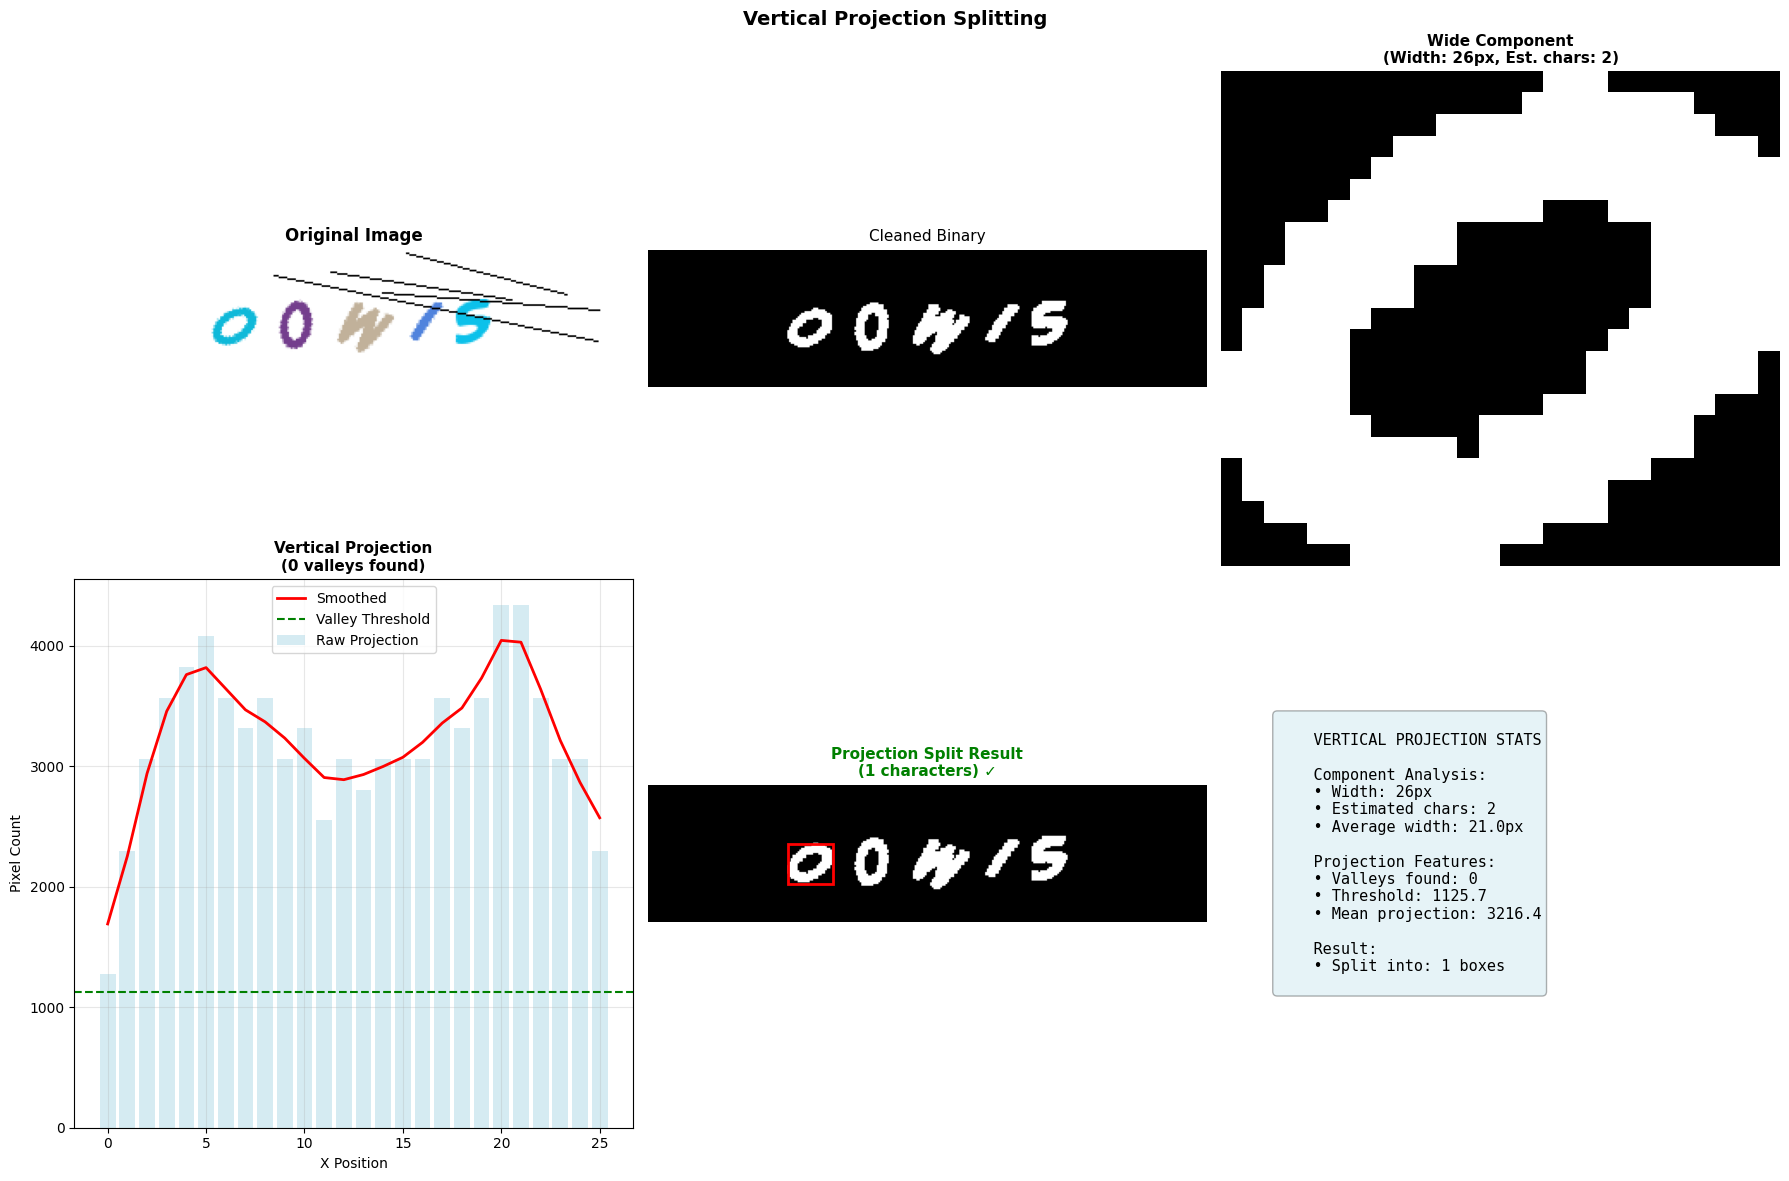

Valleys found: 0, Split into: 1 boxes

Example 2: 02cc-0 (sample #17)


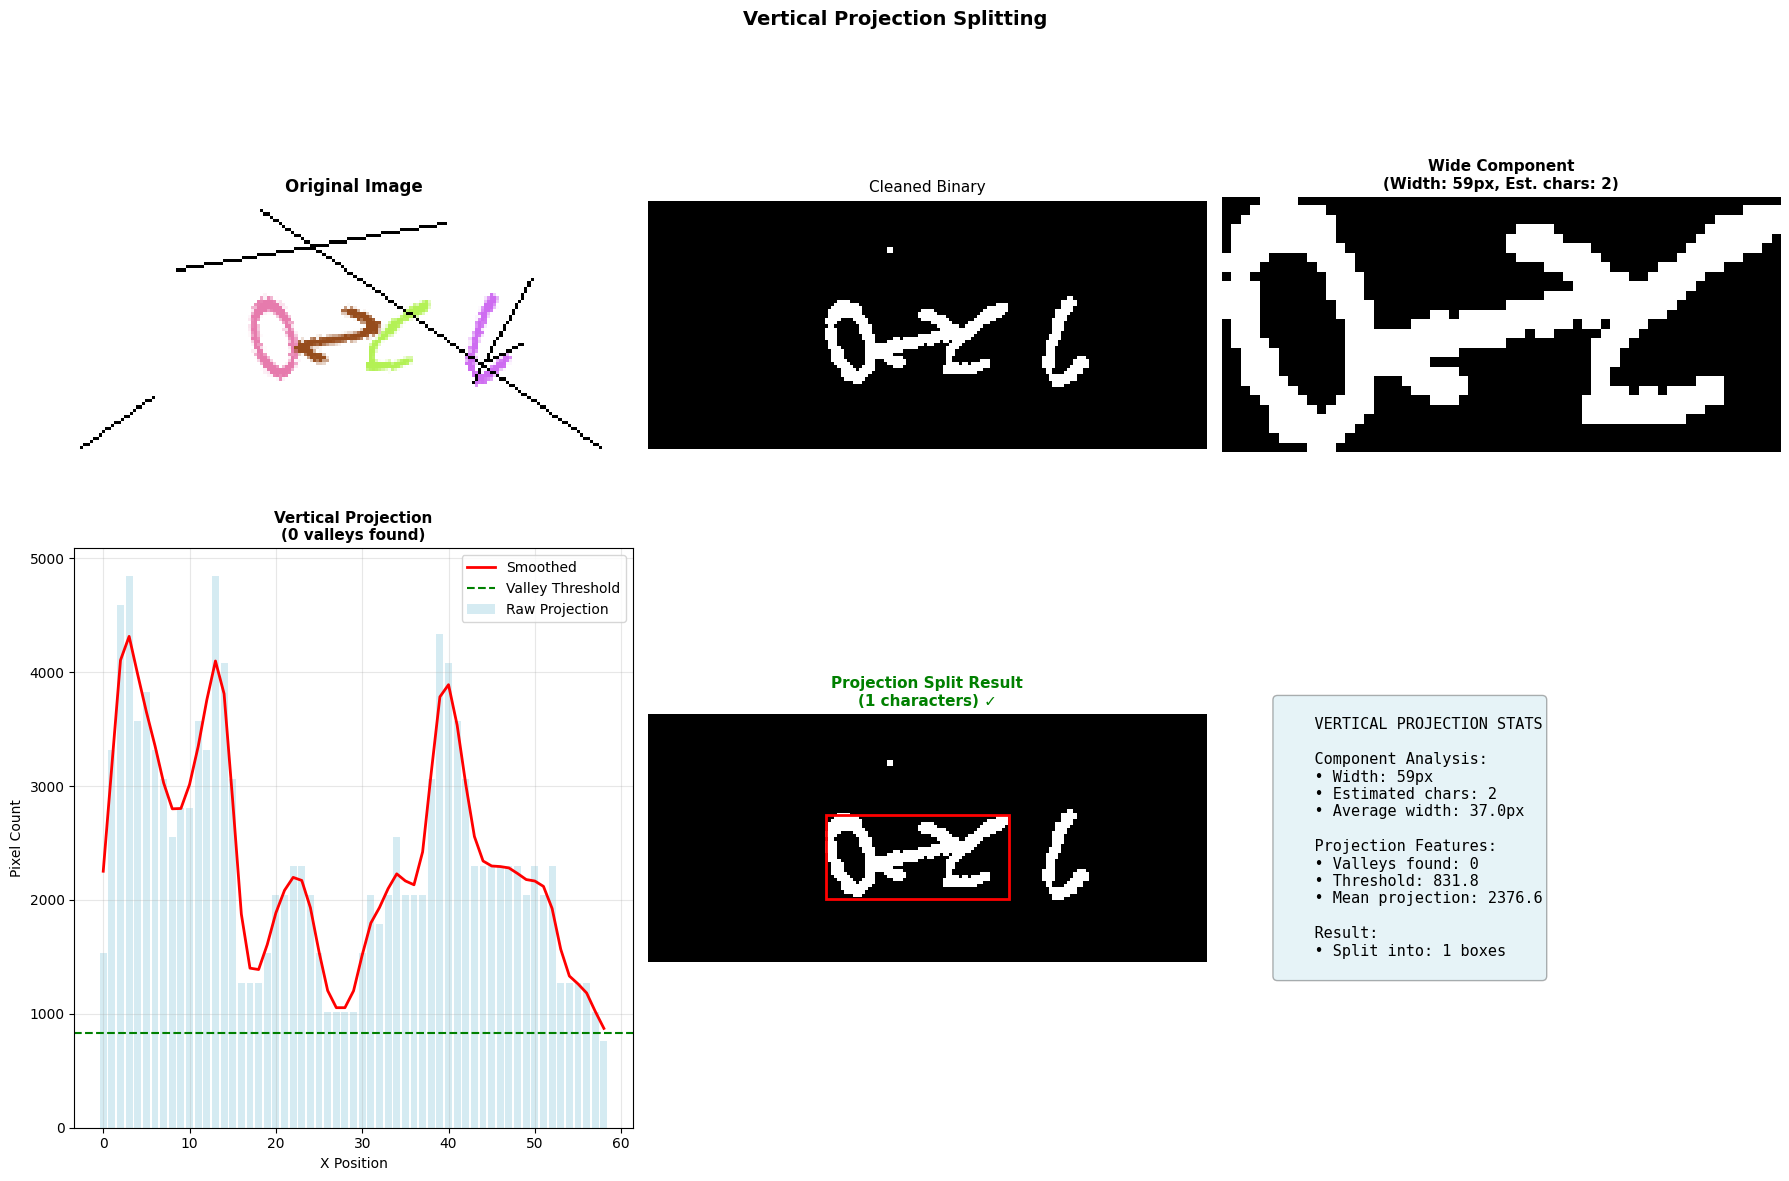

Valleys found: 0, Split into: 1 boxes

Example 3: 03mxgd-0 (sample #21)


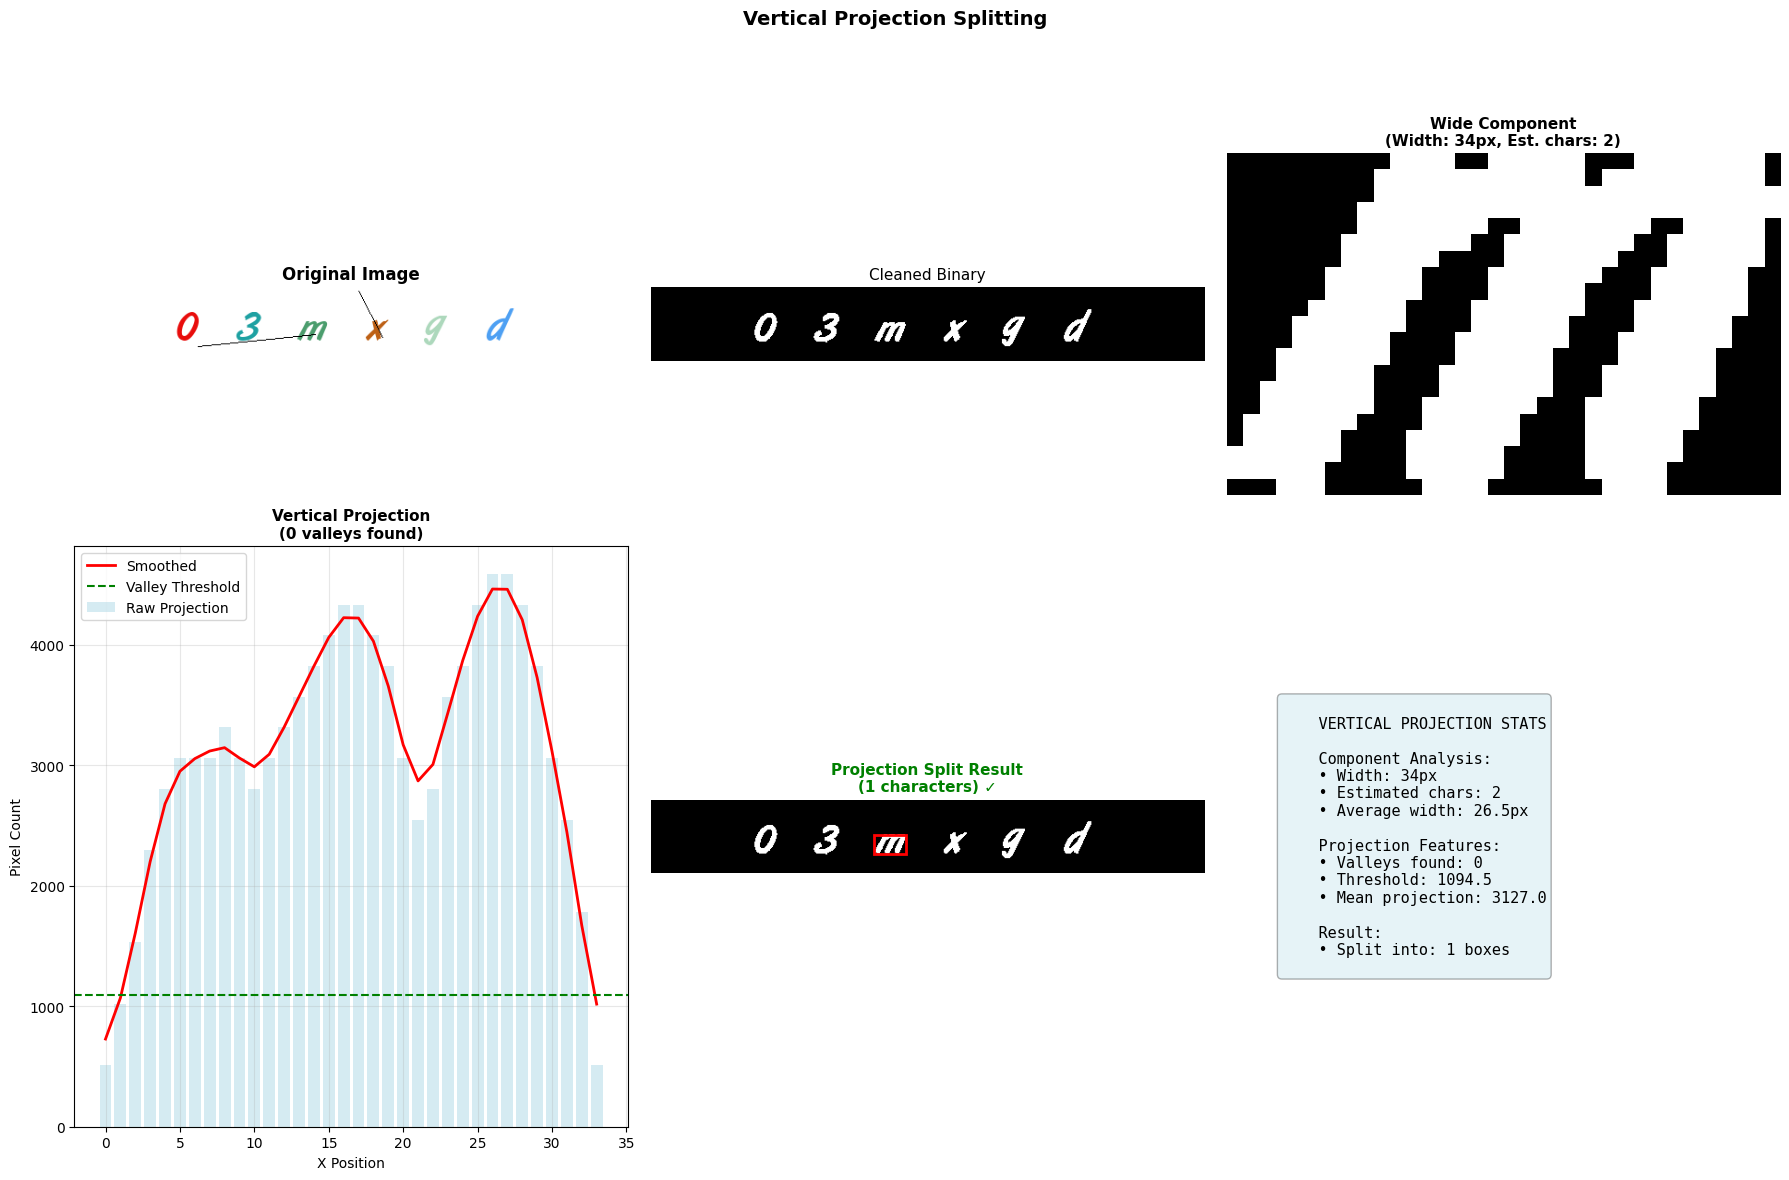

Valleys found: 0, Split into: 1 boxes



In [ ]:
# Helper function to find samples where vertical projection splitting actually succeeded
def find_samples_with_successful_splits(sample_images, sample_labels, preprocessor, segmenter, 
                                       min_width=30, max_samples=1000):
    """Find samples where vertical projection splitting actually succeeded"""
    successful_samples = []
    
    for idx, (img, label) in enumerate(zip(sample_images[:max_samples], sample_labels[:max_samples])):
        try:
            binary = preprocessor.preprocess(img)
            cleaned = segmenter._clean_image(binary)
            components = segmenter._find_character_regions(cleaned, min_width=5, min_height=10)
            
            if len(components) == 0:
                continue
            
            # Find wide components
            avg_width = np.median([c[2] - c[0] for c in components]) if components else 30
            wide_components = [c for c in components if (c[2] - c[0]) > max(min_width, avg_width * 1.2)]
            
            # If no wide components with strict threshold, try more lenient
            if len(wide_components) == 0:
                for threshold_mult in [1.1, 1.0]:
                    wide_components = [c for c in components if (c[2] - c[0]) > avg_width * threshold_mult]
                    if len(wide_components) > 0:
                        break
            
            # Test each wide component to see if projection splitting succeeds
            for box in wide_components:
                x1, y1, x2, y2 = box
                region = cleaned[y1:y2, x1:x2]
                
                # Calculate projection
                vertical_proj = np.sum(region, axis=0)
                vertical_proj_smooth = gaussian_filter1d(vertical_proj, sigma=1)
                
                # Estimate characters
                estimated_chars = max(2, int((x2 - x1) / avg_width + 0.3))
                
                # Find valleys
                if estimated_chars >= 3:
                    threshold = np.mean(vertical_proj_smooth) * 0.20
                else:
                    threshold = np.mean(vertical_proj_smooth) * 0.25
                
                valleys = []
                for i in range(2, len(vertical_proj_smooth) - 2):
                    if (vertical_proj_smooth[i] < threshold and 
                        vertical_proj_smooth[i] < vertical_proj_smooth[i-1] and 
                        vertical_proj_smooth[i] < vertical_proj_smooth[i+1]):
                        valleys.append(i)
                
                # Try more permissive threshold if no valleys
                if len(valleys) == 0 and estimated_chars >= 2:
                    threshold = np.mean(vertical_proj_smooth) * 0.35
                    for i in range(2, len(vertical_proj_smooth) - 2):
                        if (vertical_proj_smooth[i] < threshold and 
                            vertical_proj_smooth[i] < vertical_proj_smooth[i-1] and 
                            vertical_proj_smooth[i] < vertical_proj_smooth[i+1]):
                            valleys.append(i)
                
                # Filter valleys
                if len(valleys) > 1:
                    filtered_valleys = [valleys[0]]
                    min_distance = max(3, region.shape[1] // (estimated_chars + 1))
                    for valley in valleys[1:]:
                        if valley - filtered_valleys[-1] >= min_distance:
                            filtered_valleys.append(valley)
                    valleys = filtered_valleys
                
                # Try actual split
                split_boxes = segmenter._vertical_projection_split(region, x1, y1, estimated_chars)
                
                # Check if split was successful (more than 1 box returned)
                if len(split_boxes) > 1:
                    successful_samples.append((idx, img, label, box, split_boxes, valleys, estimated_chars))
                    
                    if len(successful_samples) >= 5:  # Get more examples
                        break
            
            if len(successful_samples) >= 5:
                break
                
        except Exception as e:
            continue
    
    return successful_samples

# Visualize Vertical Projection Splitting (with pre-computed data for successful splits)
def visualize_vertical_projection_with_data(image, preprocessor, segmenter, box, split_boxes, valleys, estimated_chars):
    """Visualize vertical projection splitting using pre-computed successful split data"""
    
    # Preprocess to get binary
    binary = preprocessor.preprocess(image)
    cleaned = segmenter._clean_image(binary)
    
    x1, y1, x2, y2 = box
    region = cleaned[y1:y2, x1:x2]
    
    # Calculate projection for visualization
    vertical_proj = np.sum(region, axis=0)
    vertical_proj_smooth = gaussian_filter1d(vertical_proj, sigma=1)
    
    # Calculate threshold for display
    if estimated_chars >= 3:
        threshold = np.mean(vertical_proj_smooth) * 0.20
    else:
        threshold = np.mean(vertical_proj_smooth) * 0.25
    
    # If no valleys with strict threshold, use permissive
    if len(valleys) == 0:
        threshold = np.mean(vertical_proj_smooth) * 0.35
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Row 1: Original and region
    axes[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title('Original Image', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(cleaned, cmap='gray')
    axes[0, 1].set_title('Cleaned Binary', fontsize=11)
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(region, cmap='gray')
    axes[0, 2].set_title(f'Wide Component (BEFORE SPLIT)\n(Width: {x2-x1}px, Est. chars: {estimated_chars})', 
                         fontsize=11, fontweight='bold', color='orange')
    axes[0, 2].axis('off')
    
    # Row 2: Projection and split
    axes[1, 0].bar(range(len(vertical_proj)), vertical_proj, alpha=0.5, color='lightblue', label='Raw Projection')
    axes[1, 0].plot(vertical_proj_smooth, 'r-', linewidth=2, label='Smoothed')
    axes[1, 0].axhline(threshold, color='green', linestyle='--', label='Valley Threshold')
    for valley in valleys:
        axes[1, 0].axvline(valley, color='red', linestyle='--', linewidth=2, alpha=0.7)
        axes[1, 0].plot(valley, vertical_proj_smooth[valley], 'ro', markersize=10)
    axes[1, 0].set_xlabel('X Position')
    axes[1, 0].set_ylabel('Pixel Count')
    axes[1, 0].set_title(f'Vertical Projection\n({len(valleys)} valleys found) ✓', 
                         fontsize=11, fontweight='bold', color='green')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Show split result
    axes[1, 1].imshow(cleaned, cmap='gray')
    axes[1, 1].set_title(f'SPLIT RESULT (AFTER)\n({len(split_boxes)} characters) ✓ SUCCESS', 
                        fontsize=11, fontweight='bold', color='green')
    for sx1, sy1, sx2, sy2 in split_boxes:
        rect = Rectangle((sx1, sy1), sx2-sx1, sy2-sy1, 
                        linewidth=2, edgecolor='red', facecolor='none')
        axes[1, 1].add_patch(rect)
    axes[1, 1].axis('off')
    
    # Statistics
    avg_width = np.median([split_boxes[i][2] - split_boxes[i][0] for i in range(len(split_boxes))])
    axes[1, 2].axis('off')
    stats_text = f"""
    ✓ SUCCESSFUL SPLIT STATS
    
    Component Analysis:
    • Original width: {x2-x1}px
    • Estimated chars: {estimated_chars}
    • Average split width: {avg_width:.1f}px
    
    Projection Features:
    • Valleys found: {len(valleys)}
    • Threshold: {threshold:.1f}
    • Mean projection: {np.mean(vertical_proj_smooth):.1f}
    
    Split Result:
    • BEFORE: 1 component
    • AFTER: {len(split_boxes)} components ✓
    • Success: YES
    """
    axes[1, 2].text(0.1, 0.5, stats_text, fontsize=11, family='monospace',
                    verticalalignment='center',
                    bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))
    
    plt.suptitle('Vertical Projection Splitting - SUCCESSFUL EXAMPLE', 
                 fontsize=14, fontweight='bold', y=0.98, color='green')
    plt.tight_layout()
    plt.show()
    
    return {'valleys': len(valleys), 'split_boxes': len(split_boxes), 'success': True}

# Original function for fallback (when no pre-computed data)
def visualize_vertical_projection(image, preprocessor, segmenter):
    """Visualize vertical projection splitting"""
    
    # Preprocess to get binary
    binary = preprocessor.preprocess(image)
    cleaned = segmenter._clean_image(binary)
    components = segmenter._find_character_regions(cleaned, min_width=5, min_height=10)
    
    # Find a wide component
    avg_width = np.median([c[2] - c[0] for c in components]) if components else 30
    wide_components = [c for c in components if (c[2] - c[0]) > avg_width * 1.2]
    
    if len(wide_components) == 0:
        # Try with lower threshold
        for threshold in [1.1, 1.0]:
            wide_components = [c for c in components if (c[2] - c[0]) > avg_width * threshold]
            if len(wide_components) > 0:
                break
    
    if len(wide_components) == 0:
        print("No wide components found for vertical projection demonstration")
        return None
    
    box = wide_components[0]
    x1, y1, x2, y2 = box
    region = cleaned[y1:y2, x1:x2]
    
    # Calculate projection
    vertical_proj = np.sum(region, axis=0)
    vertical_proj_smooth = gaussian_filter1d(vertical_proj, sigma=1)
    
    # Estimate characters
    estimated_chars = max(2, int((x2 - x1) / avg_width + 0.3))
    
    # Find valleys
    if estimated_chars >= 3:
        threshold = np.mean(vertical_proj_smooth) * 0.20
    else:
        threshold = np.mean(vertical_proj_smooth) * 0.25
    
    valleys = []
    for i in range(2, len(vertical_proj_smooth) - 2):
        if (vertical_proj_smooth[i] < threshold and 
            vertical_proj_smooth[i] < vertical_proj_smooth[i-1] and 
            vertical_proj_smooth[i] < vertical_proj_smooth[i+1]):
            valleys.append(i)
    
    if len(valleys) == 0 and estimated_chars >= 2:
        threshold = np.mean(vertical_proj_smooth) * 0.35
        for i in range(2, len(vertical_proj_smooth) - 2):
            if (vertical_proj_smooth[i] < threshold and 
                vertical_proj_smooth[i] < vertical_proj_smooth[i-1] and 
                vertical_proj_smooth[i] < vertical_proj_smooth[i+1]):
                valleys.append(i)
    
    # Filter valleys
    if len(valleys) > 1:
        filtered_valleys = [valleys[0]]
        min_distance = max(3, region.shape[1] // (estimated_chars + 1))
        for valley in valleys[1:]:
            if valley - filtered_valleys[-1] >= min_distance:
                filtered_valleys.append(valley)
        valleys = filtered_valleys
    
    # Try split
    split_boxes = segmenter._vertical_projection_split(region, x1, y1, estimated_chars)
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Row 1: Original and region
    axes[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title('Original Image', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(cleaned, cmap='gray')
    axes[0, 1].set_title('Cleaned Binary', fontsize=11)
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(region, cmap='gray')
    axes[0, 2].set_title(f'Wide Component\n(Width: {x2-x1}px, Est. chars: {estimated_chars})', 
                         fontsize=11, fontweight='bold')
    axes[0, 2].axis('off')
    
    # Row 2: Projection and split
    axes[1, 0].bar(range(len(vertical_proj)), vertical_proj, alpha=0.5, color='lightblue', label='Raw Projection')
    axes[1, 0].plot(vertical_proj_smooth, 'r-', linewidth=2, label='Smoothed')
    axes[1, 0].axhline(threshold, color='green', linestyle='--', label='Valley Threshold')
    for valley in valleys:
        axes[1, 0].axvline(valley, color='red', linestyle='--', linewidth=2, alpha=0.7)
        axes[1, 0].plot(valley, vertical_proj_smooth[valley], 'ro', markersize=10)
    axes[1, 0].set_xlabel('X Position')
    axes[1, 0].set_ylabel('Pixel Count')
    axes[1, 0].set_title(f'Vertical Projection\n({len(valleys)} valleys found)', 
                         fontsize=11, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Show split result
    axes[1, 1].imshow(cleaned, cmap='gray')
    axes[1, 1].set_title(f'Projection Split Result\n({len(split_boxes)} characters) ✓', 
                        fontsize=11, fontweight='bold', color='green')
    for sx1, sy1, sx2, sy2 in split_boxes:
        rect = Rectangle((sx1, sy1), sx2-sx1, sy2-sy1, 
                        linewidth=2, edgecolor='red', facecolor='none')
        axes[1, 1].add_patch(rect)
    axes[1, 1].axis('off')
    
    # Statistics
    axes[1, 2].axis('off')
    stats_text = f"""
    VERTICAL PROJECTION STATS
    
    Component Analysis:
    • Width: {x2-x1}px
    • Estimated chars: {estimated_chars}
    • Average width: {avg_width:.1f}px
    
    Projection Features:
    • Valleys found: {len(valleys)}
    • Threshold: {threshold:.1f}
    • Mean projection: {np.mean(vertical_proj_smooth):.1f}
    
    Result:
    • Split into: {len(split_boxes)} boxes
    """
    axes[1, 2].text(0.1, 0.5, stats_text, fontsize=11, family='monospace',
                    verticalalignment='center',
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))
    
    plt.suptitle('Vertical Projection Splitting', 
                 fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()
    
    print(f"Valleys found: {len(valleys)}, Split into: {len(split_boxes)} boxes")
    print()
    
    return {'valleys': len(valleys), 'split_boxes': len(split_boxes)}

# Test on multiple samples - find examples where splitting actually succeeded
print("="*70)
print("TECHNIQUE 2: VERTICAL PROJECTION SPLITTING")
print("="*70)
print()
print("Searching for samples where vertical projection splitting SUCCEEDED...")
print("(This may take a moment as we test actual splits on each sample)\n")

successful_samples = find_samples_with_successful_splits(sample_images, sample_labels, preprocessor, segmenter, min_width=25)

if len(successful_samples) > 0:
    print(f"✓ Found {len(successful_samples)} samples with SUCCESSFUL splits!\n")
    print("Showing examples where vertical projection splitting worked:\n")
    
    for i, (idx, img, label, box, split_boxes, valleys, est_chars) in enumerate(successful_samples[:3]):
        print(f"{'='*70}")
        print(f"Example {i+1}: {label} (sample #{idx})")
        print(f"{'='*70}")
        print(f"✓ SUCCESS: Split {len(split_boxes)} characters from 1 wide component")
        print(f"  • Original box width: {box[2] - box[0]}px")
        print(f"  • Valleys found: {len(valleys)}")
        print(f"  • Estimated characters: {est_chars}")
        print(f"  • Actual split result: {len(split_boxes)} boxes\n")
        
        # Use the pre-found data for visualization
        visualize_vertical_projection_with_data(img, preprocessor, segmenter, box, split_boxes, valleys, est_chars)
        print()
else:
    print("⚠ No samples found with successful splits in first 1000 samples.")
    print("Showing first 3 samples for reference (may not have successful splits):\n")
    for i, (img, label) in enumerate(zip(sample_images[:3], sample_labels[:3])):
        print(f"Example {i+1}: {label}")
        visualize_vertical_projection(img, preprocessor, segmenter)


## Technique 3: Uniform Splitting (Fallback)

**Problem**: Vertical projection splitting may fail when characters are too tightly merged or when projection valleys are not clear.

**Solution**: Use uniform splitting as a fallback:
- Estimate number of characters in a wide box based on expected average width
- Divide the box uniformly into estimated number of segments
- Extract y boundaries for each segment independently
- Apply when projection splitting fails

**Improvement**: Provides a reliable fallback mechanism when projection-based methods cannot find clear split points, ensuring characters are still separated.


## Technique 4: Merge/Filter Operations

**Problem**: Over-segmentation occurs when noise or character parts are detected as separate components, resulting in more boxes than expected characters.

**Solution**: Intelligent merge and filter operations:
- **Merge**: Combine boxes that are very close or overlapping
- **Filter**: Score boxes by area, density, aspect ratio, and height
- Keep highest scoring boxes up to expected count
- Penalize very small, sparse, or oddly-shaped regions

**Improvement**: Reduces over-segmentation by intelligently combining or removing spurious detections, ensuring the correct number of character boxes.


## Technique 5: Force Uniform Split (Last Resort)

**Problem**: Severe under-segmentation where multiple characters are merged into one or two giant blobs, and standard splitting methods fail.

**Solution**: Force uniform splitting as last resort:
- Estimate characters per box based on expected width
- Force split all boxes uniformly into estimated segments
- If still insufficient, split entire image uniformly
- Ensures at least the expected number of boxes

**Improvement**: Handles extreme cases of under-segmentation where other methods fail, providing a guaranteed fallback to reach the expected character count.


## Complete Segmentation Pipeline: End-to-End

This section shows the complete segmentation pipeline from original image to final character bounding boxes, demonstrating how all techniques work together.


COMPLETE SEGMENTATION PIPELINE: END-TO-END


Example 1: 0024miih-0


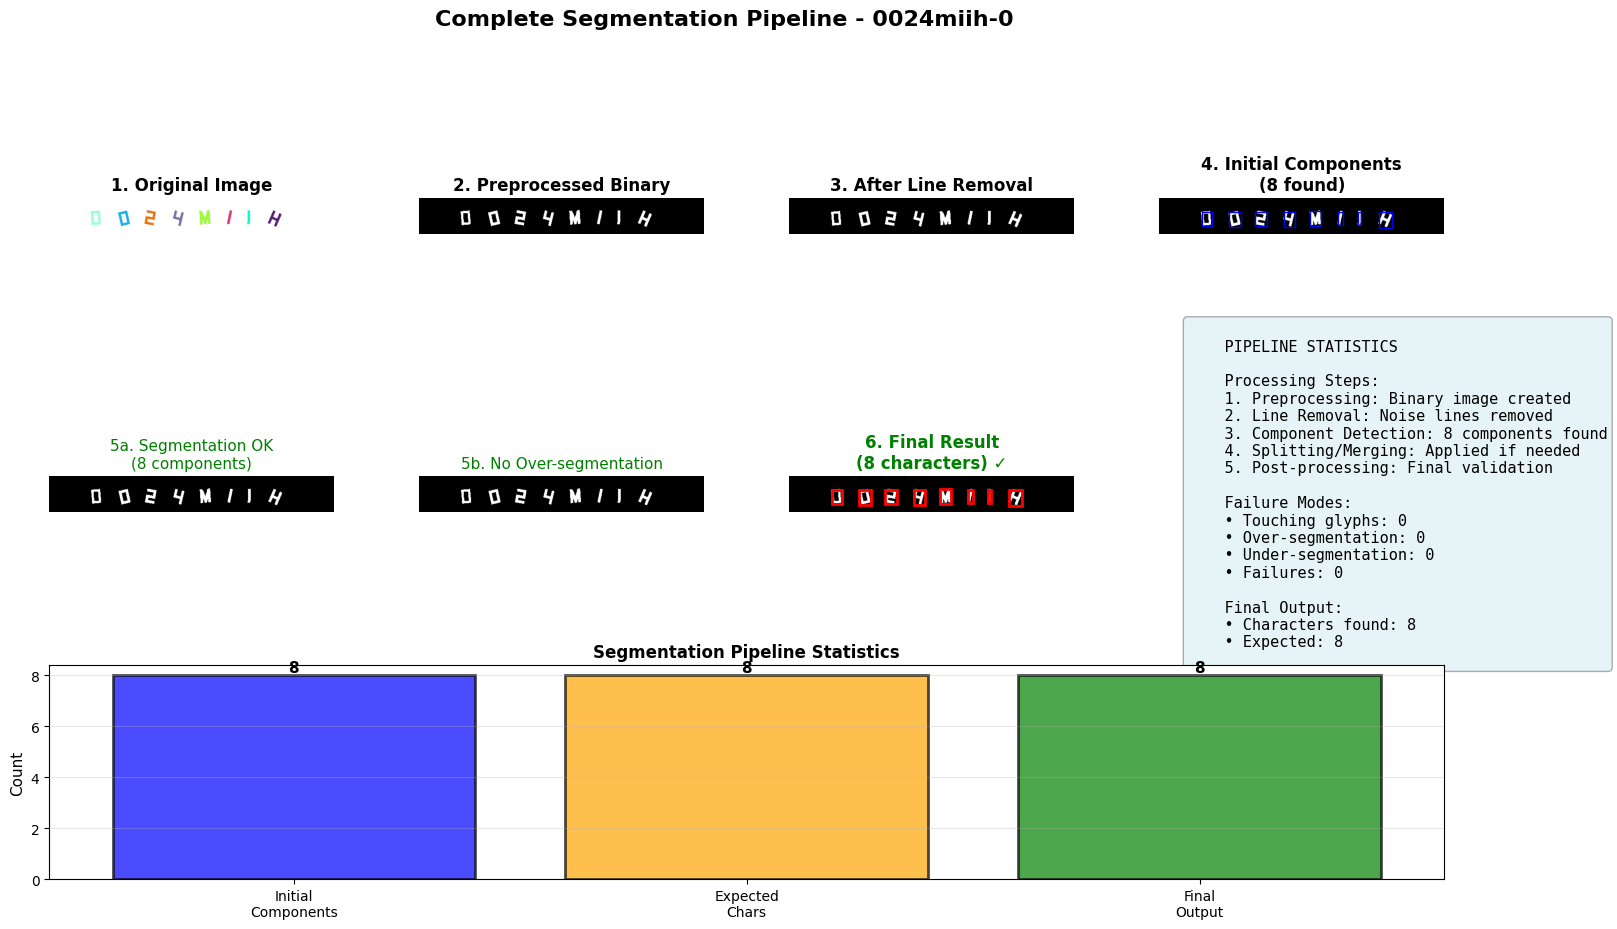



Example 2: 002e23-0


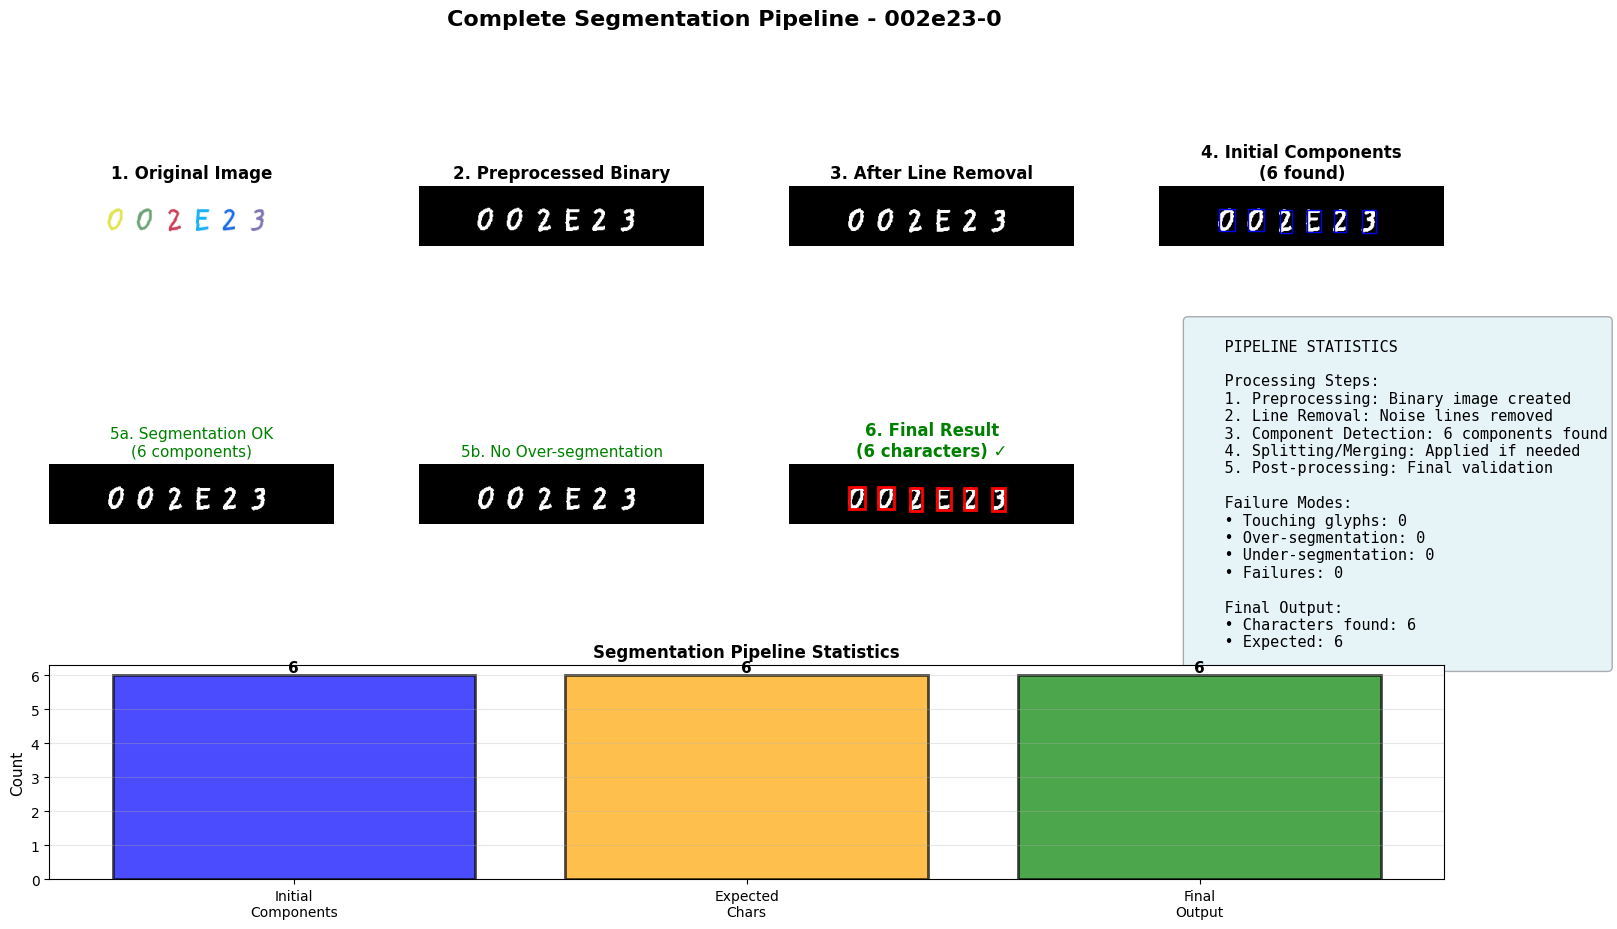



Example 3: 002k-0


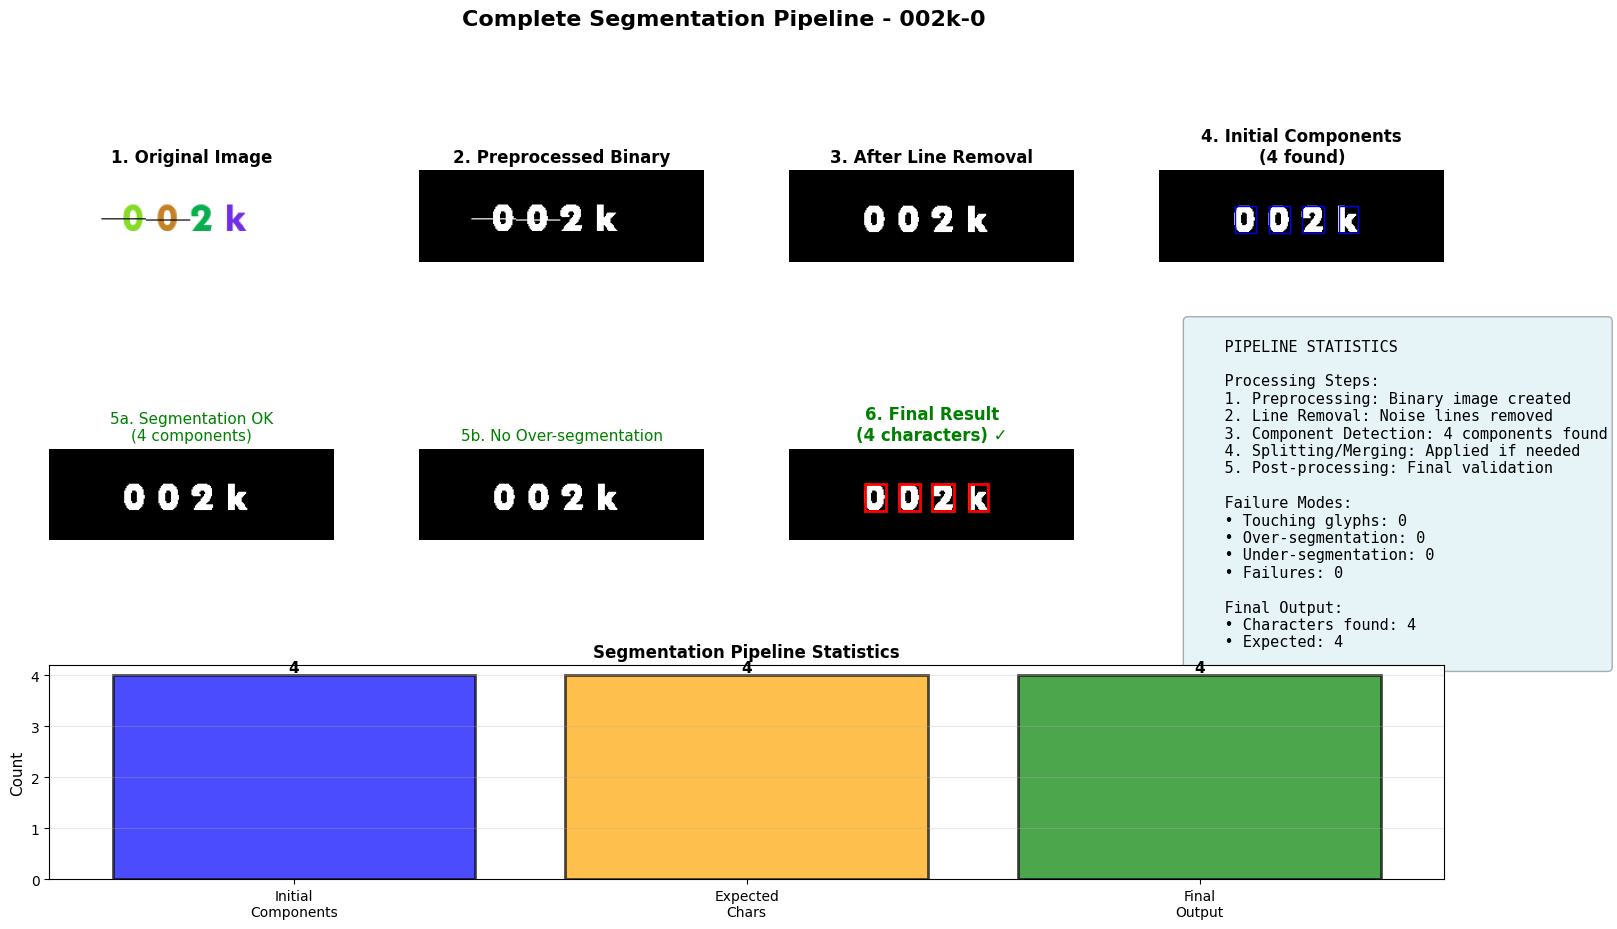

In [7]:
# Visualize Complete Segmentation Pipeline
def visualize_complete_pipeline(image, preprocessor, segmenter, label="", expected_chars=None):
    """Show the complete segmentation pipeline step-by-step"""
    
    # Step 1: Preprocess
    binary = preprocessor.preprocess(image)
    
    # Step 2: Clean image
    cleaned = segmenter._clean_image(binary)
    
    # Step 3: Find initial components
    components = segmenter._find_character_regions(cleaned, min_width=5, min_height=10)
    
    # Step 4: Run full segmentation
    if expected_chars is None:
        # Estimate from components
        expected_chars = len(components) if len(components) > 0 else 6
    
    final_boxes = segmenter.segment(binary, expected_chars=expected_chars, 
                                    min_char_width=5, min_char_height=10)
    
    # Create comprehensive visualization
    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)
    
    # Row 1: Input and preprocessing
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax1.set_title('1. Original Image', fontsize=12, fontweight='bold')
    ax1.axis('off')
    
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.imshow(binary, cmap='gray')
    ax2.set_title('2. Preprocessed Binary', fontsize=12, fontweight='bold')
    ax2.axis('off')
    
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.imshow(cleaned, cmap='gray')
    ax3.set_title('3. After Line Removal', fontsize=12, fontweight='bold')
    ax3.axis('off')
    
    # Show initial components
    ax4 = fig.add_subplot(gs[0, 3])
    ax4.imshow(cleaned, cmap='gray')
    ax4.set_title(f'4. Initial Components\n({len(components)} found)', 
                  fontsize=12, fontweight='bold')
    for x1, y1, x2, y2 in components:
        rect = Rectangle((x1, y1), x2-x1, y2-y1, 
                        linewidth=1, edgecolor='blue', facecolor='none')
        ax4.add_patch(rect)
    ax4.axis('off')
    
    # Row 2: Processing steps
    # Show if splitting was applied
    ax5 = fig.add_subplot(gs[1, 0])
    ax5.imshow(cleaned, cmap='gray')
    if len(components) < expected_chars:
        ax5.set_title(f'5a. Under-segmentation Detected\n({len(components)} < {expected_chars})', 
                     fontsize=11, color='orange')
    else:
        ax5.set_title(f'5a. Segmentation OK\n({len(components)} components)', 
                     fontsize=11, color='green')
    ax5.axis('off')
    
    # Show merge/filter if over-segmented
    ax6 = fig.add_subplot(gs[1, 1])
    ax6.imshow(cleaned, cmap='gray')
    if len(components) > expected_chars:
        ax6.set_title(f'5b. Over-segmentation Detected\n({len(components)} > {expected_chars})', 
                     fontsize=11, color='orange')
    else:
        ax6.set_title(f'5b. No Over-segmentation', 
                     fontsize=11, color='green')
    ax6.axis('off')
    
    # Final result
    ax7 = fig.add_subplot(gs[1, 2])
    ax7.imshow(cleaned, cmap='gray')
    ax7.set_title(f'6. Final Result\n({len(final_boxes)} characters) ✓', 
                  fontsize=12, fontweight='bold', color='green')
    for x1, y1, x2, y2 in final_boxes:
        rect = Rectangle((x1, y1), x2-x1, y2-y1, 
                        linewidth=2, edgecolor='red', facecolor='none')
        ax7.add_patch(rect)
    ax7.axis('off')
    
    # Statistics
    ax8 = fig.add_subplot(gs[1, 3])
    ax8.axis('off')
    stats_text = f"""
    PIPELINE STATISTICS
    
    Processing Steps:
    1. Preprocessing: Binary image created
    2. Line Removal: Noise lines removed
    3. Component Detection: {len(components)} components found
    4. Splitting/Merging: Applied if needed
    5. Post-processing: Final validation
    
    Failure Modes:
    • Touching glyphs: {segmenter.failure_modes['touching_glyphs']}
    • Over-segmentation: {segmenter.failure_modes['over_segmentation']}
    • Under-segmentation: {segmenter.failure_modes['under_segmentation']}
    • Failures: {segmenter.failure_modes['segmentation_failures']}
    
    Final Output:
    • Characters found: {len(final_boxes)}
    • Expected: {expected_chars}
    """
    ax8.text(0.1, 0.5, stats_text, fontsize=11, family='monospace',
             verticalalignment='center',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))
    
    # Row 3: Comparison chart
    ax9 = fig.add_subplot(gs[2, :])
    methods = ['Initial\nComponents', 'Expected\nChars', 'Final\nOutput']
    counts = [len(components), expected_chars, len(final_boxes)]
    colors = ['blue', 'orange', 'green']
    bars = ax9.bar(methods, counts, color=colors, alpha=0.7, 
                   edgecolor='black', linewidth=2)
    ax9.set_ylabel('Count', fontsize=11)
    ax9.set_title('Segmentation Pipeline Statistics', fontsize=12, fontweight='bold')
    ax9.grid(axis='y', alpha=0.3)
    for bar, val in zip(bars, counts):
        height = bar.get_height()
        ax9.text(bar.get_x() + bar.get_width()/2., height,
                f'{val}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    if label:
        plt.suptitle(f'Complete Segmentation Pipeline - {label}', 
                     fontsize=16, fontweight='bold', y=0.98)
    else:
        plt.suptitle('Complete Segmentation Pipeline', 
                     fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'components': components,
        'final_boxes': final_boxes,
        'expected': expected_chars
    }

# Test complete pipeline on multiple examples
print("="*70)
print("COMPLETE SEGMENTATION PIPELINE: END-TO-END")
print("="*70)
print()

for i, (img, label) in enumerate(zip(sample_images[:3], sample_labels[:3])):
    print(f"\n{'='*70}")
    print(f"Example {i+1}: {label}")
    print('='*70)
    # Estimate expected chars from label (if available)
    expected = len(label.split('-')[0]) if '-' in label else 6
    result = visualize_complete_pipeline(img, preprocessor, segmenter, label=label, expected_chars=expected)
    print()


## Summary: Segmentation Techniques and Their Impact

### Technique Comparison Table

| Technique | Problem Solved | Method | Improvement |
|-----------|---------------|--------|-------------|
| **Connected Components** | Need to identify character regions | Contour detection with filtering | Foundation for all segmentation |
| **Vertical Projection** | Touching characters form single component | Analyze pixel distribution valleys | Splits touching characters accurately |
| **Uniform Splitting** | Projection splitting fails | Divide box uniformly by estimated chars | Reliable fallback for merged characters |
| **Merge/Filter** | Over-segmentation from noise | Score and filter boxes intelligently | Reduces false positives |
| **Force Uniform Split** | Severe under-segmentation | Force split all boxes uniformly | Last resort for extreme cases |

### Key Insights

1. **Connected Components** provides the base segmentation method
2. **Vertical Projection** handles most touching character cases effectively
3. **Uniform Splitting** ensures robustness when projection fails
4. **Merge/Filter** prevents over-segmentation from noise
5. **Force Uniform Split** handles extreme under-segmentation cases
6. **Combined approach** provides a complete pipeline with multiple fallback mechanisms
